In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import  AdaBoostClassifier
from sklearn.svm import SVC
import sklearn.naive_bayes as nb
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

from sklearn import metrics


import warnings
warnings.simplefilter('ignore')

In [2]:
data=pd.read_csv("bankchurn.csv")
data

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


In [4]:
data.isnull().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [5]:
#deleting duplicates
print('Size of dataframe before drop_duplicates', data.shape)

data.drop_duplicates(inplace= True)

print('Size of dataframe after drop_duplicates', data.shape)

Size of dataframe before drop_duplicates (10000, 13)
Size of dataframe after drop_duplicates (10000, 13)


In [6]:
#Seprating out the categorical and continuous variables
def seperate_data_types(data):
    categorical=[]
    continuous=[]
    for column in data.columns:
        if data[column].nunique () < 100:
            categorical.append(column)
        else:
            continuous.append(column)
    return categorical, continuous

categorical, continuous=seperate_data_types(data)

from tabulate import tabulate

Lable=[categorical, continuous]

print(tabulate({"Categorical":categorical,"continuous": continuous}, headers = ["categorical", "continuous"]))

categorical     continuous
--------------  ---------------
Geography       CustomerId
Gender          Surname
Age             CreditScore
Tenure          Balance
NumOfProducts   EstimatedSalary
HasCrCard
IsActiveMember
Exited


In [7]:
! pip install tabulate

In [8]:
data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [9]:
categorical.remove("Age")
continuous.append("Age")

continuous.remove("Surname")
categorical.append("Surname")

In [10]:
data.Age.dtype

dtype('int64')

# Outlier Treatment

In [11]:
print("row and column before removing outliers:",data.shape)

def myoutliers(data,col):
    Q3=np.quantile(data[col],0.75)
    Q1=np.quantile(data[col],0.25)
    
    IQR=Q3-Q1
    
    global mylist
    global my_outlier_df
    
    lower_range=Q1-1.5*IQR
    upper_range=Q3+1.5*IQR
    
    print('the lower range of',col,"is",lower_range)
    print("the upper range of ",col,"is",upper_range)
    
    mylist=[x for x in data[col] if ((x<lower_range)|(x>upper_range))]
    print("total outliers in",col,"are",len(mylist))
    my_outlier_df=data.loc[data[col].isin(mylist)]
    
k=['CreditScore','Balance','EstimatedSalary','Age','Tenure']        


for i in k:
    print("i is ",i)
    myoutliers(data,i)
    print("***************")

row and column before removing outliers: (10000, 13)
i is  CreditScore
the lower range of CreditScore is 383.0
the upper range of  CreditScore is 919.0
total outliers in CreditScore are 15
***************
i is  Balance
the lower range of Balance is -191466.36000000002
the upper range of  Balance is 319110.60000000003
total outliers in Balance are 0
***************
i is  EstimatedSalary
the lower range of EstimatedSalary is -96577.09624999999
the upper range of  EstimatedSalary is 296967.45375
total outliers in EstimatedSalary are 0
***************
i is  Age
the lower range of Age is 14.0
the upper range of  Age is 62.0
total outliers in Age are 359
***************
i is  Tenure
the lower range of Tenure is -3.0
the upper range of  Tenure is 13.0
total outliers in Tenure are 0
***************


In [12]:
#data["Exited"].nunique(axis=0)
data["Exited"].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

## Univariate Analysis

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

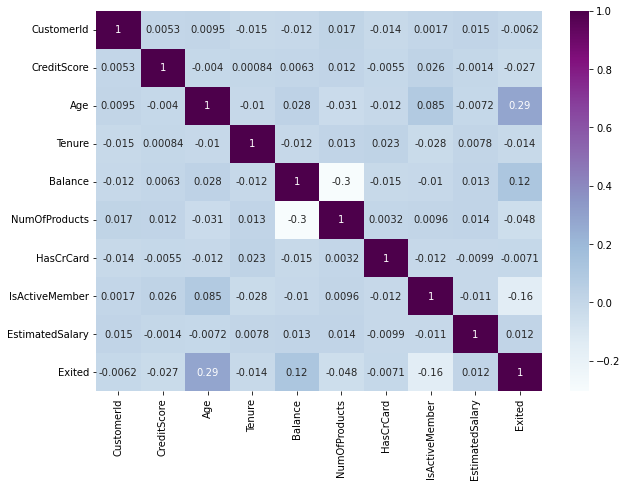

In [14]:
fig,ax=plt.subplots(figsize=(10,7))
sns.heatmap(data.corr(),annot=True,cmap="BuPu")
plt.show()

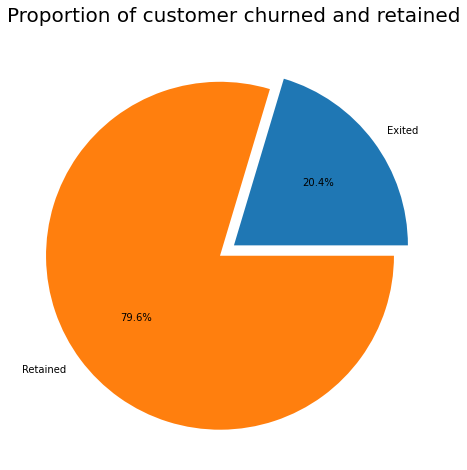

In [15]:
labels = 'Exited', 'Retained'
sizes = [data.Exited[data['Exited']==1].count(), data.Exited[data['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

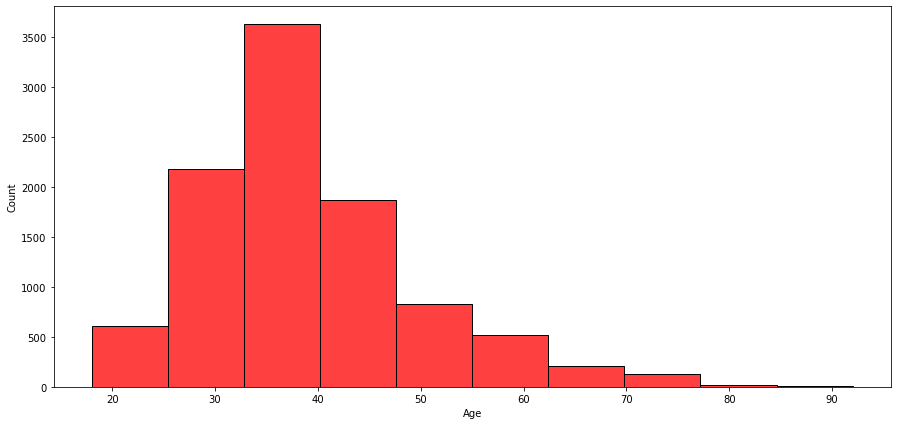

In [16]:
fig,ax=plt.subplots(figsize=(15,7))
sns.histplot(x=data['Age'], bins=10,color='r')
#sns.boxplot(y=data['Age'],ax=ax[1]).set(title='Age')
plt.show()

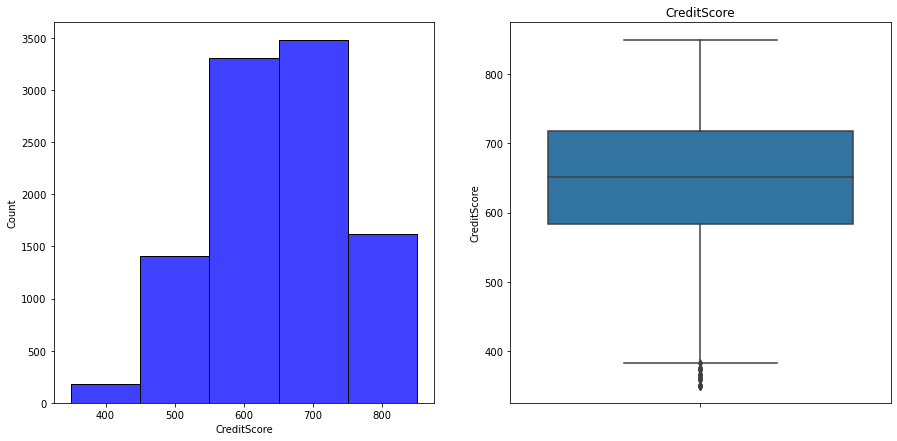

In [17]:
fig,ax=plt.subplots(1,2,figsize=(15,7))
sns.histplot(x=data['CreditScore'],ax=ax[0],bins=5,color='b')
sns.boxplot(y=data['CreditScore'],ax=ax[1]).set(title='CreditScore')
plt.show()

## Bivariate

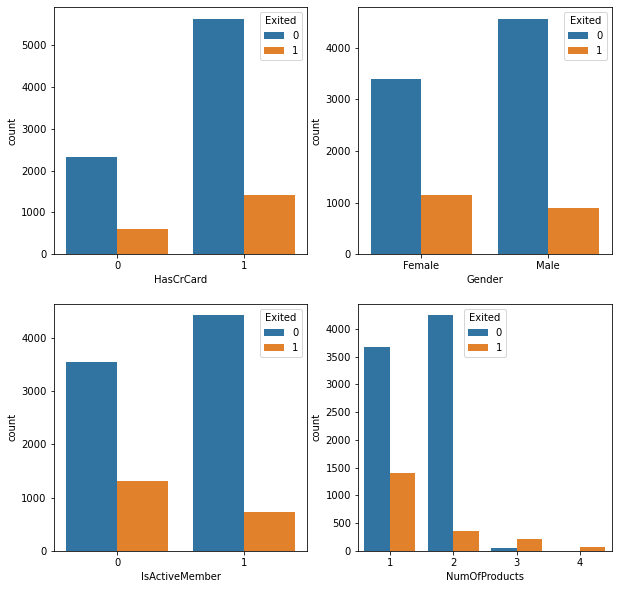

In [18]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
sns.countplot(x='HasCrCard',hue='Exited',data=data,ax=ax[0,0])
ax[0,0].set_title('')
sns.countplot(x='Gender',hue='Exited',data=data,ax=ax[0,1])
ax[0,1].set_title('')
sns.countplot(x='IsActiveMember',hue='Exited',data=data,ax=ax[1,0])
ax[1,0].set_title('')
sns.countplot(x='NumOfProducts',hue='Exited',data=data,ax=ax[1,1])
ax[1,1].set_title('')
plt.show()  

<AxesSubplot:xlabel='Geography', ylabel='count'>

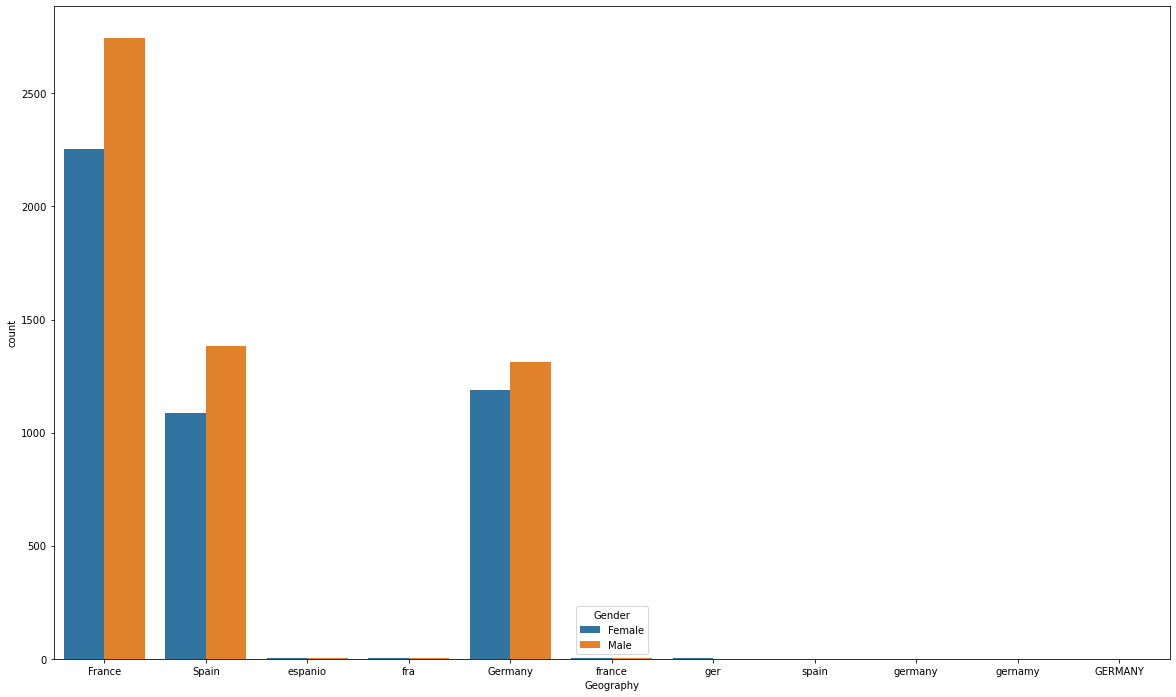

In [19]:
fig, axarr = plt.subplots(figsize=(20, 12))
sns.countplot(x='Geography', hue = 'Gender',data = data)

## Multivariate

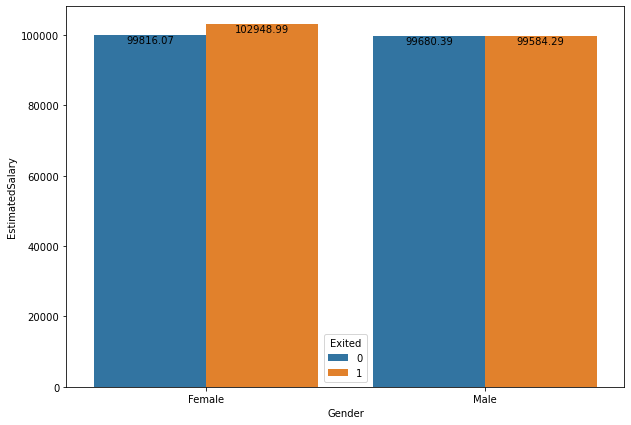

In [20]:
fig,ax= plt.subplots(figsize=(10,7))
sns.barplot(x=data['Gender'],y=data['EstimatedSalary'],hue=data['Exited'],ci=None,ax=ax)
count=len(data['Gender'])

for bar in ax.patches:
        count = f"{round((bar.get_height()), 2)}" 
        x = bar.get_x() +bar.get_width() /2 
        y=bar.get_height() 
        ax.annotate (count, (x, y), ha = "center", va = "top")
plt.show()


In [21]:
data = pd.get_dummies(data, columns =["Geography", "Gender"], drop_first = False)

In [22]:
data

,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Geography_Spain,Geography_espanio,Geography_fra,Geography_france,Geography_ger,Geography_germany,Geography_gernamy,Geography_spain,Gender_Female,Gender_Male
0,15634602,Hargrave,619,42,2,0.00,1,1,1,101348.88,...,0,0,0,0,0,0,0,0,1,0
1,15647311,Hill,608,41,1,83807.86,1,0,1,112542.58,...,1,0,0,0,0,0,0,0,1,0
2,15619304,Onio,502,42,8,159660.80,3,1,0,113931.57,...,0,0,0,0,0,0,0,0,1,0
3,15701354,Boni,699,39,1,0.00,2,0,0,93826.63,...,0,0,0,0,0,0,0,0,1,0
4,15737888,Mitchell,850,43,2,125510.82,1,1,1,79084.10,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,Obijiaku,771,39,5,0.00,2,1,0,96270.64,...,0,0,0,0,0,0,0,0,0,1
9996,15569892,Johnstone,516,35,10,57369.61,1,1,1,101699.77,...,0,0,0,0,0,0,0,0,0,1
9997,15584532,Liu,709,36,7,0.00,1,0,1,42085.58,...,0,0,0,0,0,0,0,0,1,0
9998,15682355,Sabbatini,772,42,3,75075.31,2,1,0,92888.52,...,0,0,0,0,0,0,0,0,0,1


In [23]:
data.columns

Index(['CustomerId', 'Surname', 'CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'Geography_France', 'Geography_GERMANY', 'Geography_Germany',
       'Geography_Spain', 'Geography_espanio', 'Geography_fra',
       'Geography_france', 'Geography_ger', 'Geography_germany',
       'Geography_gernamy', 'Geography_spain', 'Gender_Female', 'Gender_Male'],
      dtype='object')

In [24]:
data.drop(['CustomerId', 'Surname'], axis='columns', inplace=True)

## Scaling the data

In [25]:
from sklearn.preprocessing import MinMaxScaler
MinMax_scaler = MinMaxScaler()

scale_columns = ['CreditScore','EstimatedSalary','Balance']
data[scale_columns] = MinMax_scaler.fit_transform(data[scale_columns])

data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,...,Geography_Spain,Geography_espanio,Geography_fra,Geography_france,Geography_ger,Geography_germany,Geography_gernamy,Geography_spain,Gender_Female,Gender_Male
0,0.538,42,2,0.000000,1,1,1,0.506735,1,1,...,0,0,0,0,0,0,0,0,1,0
1,0.516,41,1,0.334031,1,0,1,0.562709,0,0,...,1,0,0,0,0,0,0,0,1,0
2,0.304,42,8,0.636357,3,1,0,0.569654,1,1,...,0,0,0,0,0,0,0,0,1,0
3,0.698,39,1,0.000000,2,0,0,0.469120,0,1,...,0,0,0,0,0,0,0,0,1,0
4,1.000,43,2,0.500246,1,1,1,0.395400,0,0,...,1,0,0,0,0,0,0,0,1,0


In [26]:
MODEL = []
accuracy = []
recall =  [] 
f1score = []
precision = []


In [27]:
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [28]:
x=data.drop('Exited', axis=1)
y=data['Exited']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=42)
print("X_train={},X_test={},y_train={},y_test={}".format(X_train.shape,X_test.shape,y_train.shape,y_test.shape))

X_train=(7500, 21),X_test=(2500, 21),y_train=(7500,),y_test=(2500,)


In [30]:
# Logistic Regression - training the model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
# Using the trained model to predict the outcome of the X_Test dataset
pred_log = logreg.predict(X_test)
#Calculating the accuracy of the training dataset
acc_log = round(logreg.score(X_train, y_train) * 100, 2)

In [31]:
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

print('accuracy:', accuracy_score(y_test, pred_log))
print('recall:', recall_score(y_test, pred_log, average='weighted'))
print('f1-score:', f1_score(y_test, pred_log, average='weighted'))
print('precision:', precision_score(y_test,pred_log))

accuracy: 0.8076
recall: 0.8076
f1-score: 0.7684698791190594
precision: 0.5459770114942529


In [32]:
acc_log=accuracy_score(y_test, pred_log)
acc_log

0.8076

In [33]:
MODEL.append('Logistic Regression')
accuracy.append(accuracy_score(y_test, pred_log))
recall.append( recall_score(y_test, pred_log,average='weighted'))
f1score.append(f1_score(y_test, pred_log,average='weighted'))
precision.append(precision_score(y_test,pred_log))

## KNeighborsClassifier

In [34]:
from sklearn.neighbors import KNeighborsClassifier

In [35]:
model = KNeighborsClassifier(n_neighbors=3)#k value

model.fit(X_train, y_train)

pred_KNN= model.predict(X_test)

acc_KNN = round(model.score(X_train, y_train) * 100, 2)

In [36]:
acc_KNN =accuracy_score(y_test, pred_KNN)
acc_KNN

0.8176

In [37]:
MODEL.append('KNeighborsClassifier')
accuracy.append(accuracy_score(y_test,pred_KNN))
recall.append( recall_score(y_test,pred_KNN,average='weighted'))
f1score.append(f1_score(y_test, pred_KNN,average='weighted'))
precision.append(precision_score(y_test,pred_KNN))

## DecisionTreeClassifier

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [39]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
pred_DTC = clf.predict(X_test)

In [40]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, pred_DTC))

Accuracy: 0.8496


In [41]:
acc_DTC=metrics.accuracy_score(y_test, pred_DTC)
acc_DTC

0.8496

In [42]:
print('accuracy:', accuracy_score(y_test, pred_DTC))
print('recall:', recall_score(y_test, pred_DTC, average='weighted'))
print('f1-score:', f1_score(y_test, pred_DTC, average='weighted'))
print('precision:', precision_score(y_test, pred_DTC))

accuracy: 0.8496
recall: 0.8496
f1-score: 0.8352340034811641
precision: 0.6970684039087948


In [43]:
MODEL.append('DecisionTreeClassifier')
accuracy.append(accuracy_score(y_test,pred_DTC))
recall.append( recall_score(y_test, pred_DTC,average='weighted'))
f1score.append(f1_score(y_test, pred_DTC,average='weighted'))
precision.append(precision_score(y_test,pred_DTC))

## RandomForestClassifier

In [44]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
model=RandomForestClassifier()
model.fit(X_train,y_train)
y_RFC=model.predict(X_test)
y_RFC

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [46]:
print('accuracy:', accuracy_score(y_test, y_RFC))
print('recall:', recall_score(y_test, y_RFC, average='weighted'))
print('f1-score:', f1_score(y_test, y_RFC, average='weighted'))
print('precision:', precision_score(y_test, y_RFC))

accuracy: 0.868
recall: 0.868
f1-score: 0.8543349176172369
precision: 0.7830508474576271


In [47]:
acc_RFC=accuracy_score(y_test, y_RFC)
acc_RFC

0.868

In [48]:
MODEL.append('RandomForestClassifier')
accuracy.append(accuracy_score(y_test, y_RFC))
recall.append( recall_score(y_test, y_RFC,average='weighted'))
f1score.append(f1_score(y_test, y_RFC,average='weighted'))
precision.append(precision_score(y_test,y_RFC))

## Naive Bayes

In [49]:
import sklearn.naive_bayes as nb
from sklearn.naive_bayes import GaussianNB

In [50]:

gnb = nb.GaussianNB()
GNB=gnb.fit(X_train, y_train)
y_nb = GNB.predict(X_test)

In [51]:
print('accuracy:', accuracy_score(y_test, y_nb))
print('recall:', recall_score(y_test, y_nb, average='weighted'))
print('f1-score:', f1_score(y_test, y_nb, average='weighted'))
print('precision:', precision_score(y_test, y_nb))

accuracy: 0.1992
recall: 0.1992
f1-score: 0.06675661014419759
precision: 0.19887955182072828


In [52]:
acc_nb=accuracy_score(y_test, y_nb)
acc_nb

0.1992

In [53]:
MODEL.append('Naive Bayes')
accuracy.append(accuracy_score(y_test, y_nb))
recall.append( recall_score(y_test, y_nb,average='weighted'))
f1score.append(f1_score(y_test,y_nb,average='weighted'))
precision.append(precision_score(y_test,y_nb))

# AdaBoostClassifier

In [54]:
from sklearn.ensemble import  AdaBoostClassifier
model_ad = AdaBoostClassifier()

model_ad.fit(X_train,y_train)
pred = model_ad.predict(X_test)


print('recall:', recall_score(y_test, pred, average='weighted'))
print('f1-score:', f1_score(y_test, pred, average='weighted'))
print('precision:', precision_score(y_test,pred))

recall: 0.8556
f1-score: 0.8433750113597976
precision: 0.7098765432098766


In [55]:
MODEL.append('AdaBoostClassifier')
accuracy.append(accuracy_score(y_test, pred))
recall.append( recall_score(y_test, pred,average='weighted'))
f1score.append(f1_score(y_test,pred,average='weighted'))
precision.append(precision_score(y_test,pred))

## Stacking

In [56]:
from sklearn.ensemble import StackingClassifier


In [57]:
def stacking():

    level0 = list()
    level0.append(('ada', AdaBoostClassifier()))
    level0.append(('cart', DecisionTreeClassifier()))
    level0.append(('rfr', RandomForestClassifier()))

    level1 = LogisticRegression()

    model_s= StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model_s

In [58]:
stack = stacking()

stack.fit(X_train,y_train)

y_pred = stack.predict(X_test)

#print('accuracy = {}%'.format(round(stc.score(y_test, y_pred) * 100, 2)))
print('recall:', recall_score(y_test, y_pred, average='weighted'))
print('f1-score:', f1_score(y_test, y_pred, average='weighted'))
print('precision:', precision_score(y_test,y_pred))


recall: 0.8672
f1-score: 0.8545151307333685
precision: 0.7687296416938111


In [59]:
MODEL.append('Stacking')
accuracy.append(accuracy_score(y_test, y_pred))
recall.append( recall_score(y_test, y_pred,average='weighted'))
f1score.append(f1_score(y_test,y_pred,average='weighted'))
precision.append(precision_score(y_test,y_pred))

## Actual VS Prediction for RandomForestClassifier

In [60]:
series_pred = pd.Series(y_RFC)

In [61]:
df_result = pd.DataFrame(data=series_pred, columns=['prediction'])
df = pd.merge(df_result, y_test, left_index=True, right_index=True)
df.head(10)

,prediction,Exited
0,0,1
3,0,0
8,0,0
10,1,0
12,1,0
14,0,0
17,0,0
19,0,0
20,0,0
23,0,0


## Actual VS Prediction for Stacking

In [84]:
series_pred1 = pd.Series(y_pred)

In [85]:
df_result1 = pd.DataFrame(data=series_pred1, columns=['prediction'])
df1 = pd.merge(df_result1, y_test, left_index=True, right_index=True)
df1.head(10)

,prediction,Exited
0,0,1
3,0,0
8,0,0
10,1,0
12,1,0
14,0,0
17,0,0
19,0,0
20,0,0
23,0,0


In [87]:
df1.value_counts(normalize=True)

prediction  Exited
0           0         0.709627
            1         0.170807
1           0         0.096273
            1         0.023292
dtype: float64

In [65]:
pd.DataFrame({'Model' : MODEL,'accuracy':accuracy,'recall':recall,'f1score':f1score,'precision':precision})


,Model,accuracy,recall,f1score,precision
0,Logistic Regression,0.8076,0.8076,0.768470,0.545977
1,KNeighborsClassifier,0.8176,0.8176,0.805522,0.557746
2,DecisionTreeClassifier,0.8496,0.8496,0.835234,0.697068
3,RandomForestClassifier,0.8680,0.8680,0.854335,0.783051
4,Naive Bayes,0.1992,0.1992,0.066757,0.198880
5,AdaBoostClassifier,0.8556,0.8556,0.843375,0.709877
6,Stacking,0.8672,0.8672,0.854515,0.768730


# AUC curve for our best Model--->Stacking

In [66]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score


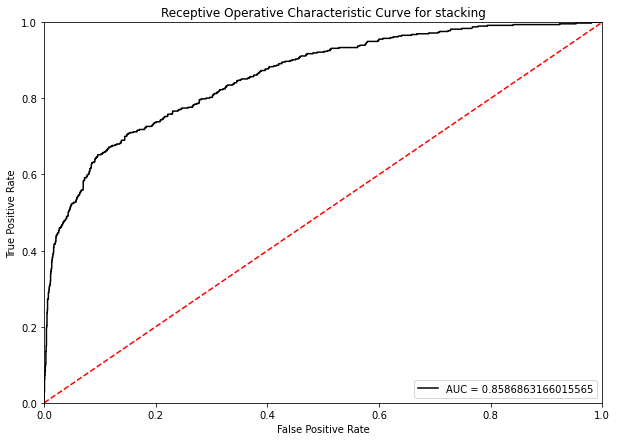

In [67]:
fpr, tpr, threshold = roc_curve(y_test,stack.predict_proba(X_test)[:,1])
area_under_curve = auc(fpr, tpr)

plt.figure(figsize = (10,7))
plt.title('Receptive Operative Characteristic Curve for stacking')
plt.plot(fpr,tpr,'b',label = 'AUC = ' + str(area_under_curve), c = 'k')
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],'r',linestyle='dashed')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### AUC of the Stacking is 0.857
   ==> it's a good model

   CrossValMeans  CrossValerrors             Algorithm
0       0.809333        0.007242    LogisticRegression
1       0.858933        0.004079          RandomForest
2       0.815867        0.007881           KNeighboors
3       0.794667        0.000000                   SVC
4       0.788400        0.007025          DecisionTree
5       0.205333        0.000422             NaiveByes
6       0.851600        0.010529  Ada Boost Classifier
7       0.855333        0.005164              Stacking


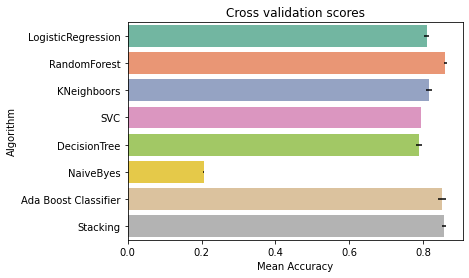

In [68]:
# Cross validate model with Kfold stratified cross validation
kfold = StratifiedKFold(n_splits=5)
# Modeling step Test differents algorithms 
classifiers = []
classifiers.append(LogisticRegression())
classifiers.append(RandomForestClassifier())
classifiers.append(KNeighborsClassifier())
classifiers.append(SVC())
classifiers.append(DecisionTreeClassifier())
classifiers.append(nb.GaussianNB())
classifiers.append(AdaBoostClassifier())
classifiers.append(stacking())
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["LogisticRegression","RandomForest","KNeighboors","SVC","DecisionTree","NaiveByes","Ada Boost Classifier","Stacking"]})
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set2",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")
print(cv_res)

In [69]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.809333,0.007242,LogisticRegression
1,0.858933,0.004079,RandomForest
2,0.815867,0.007881,KNeighboors
3,0.794667,0.000000,SVC
4,0.788400,0.007025,DecisionTree
5,0.205333,0.000422,NaiveByes
6,0.851600,0.010529,Ada Boost Classifier
7,0.855333,0.005164,Stacking


# Model Summary for Logistic Regression

In [70]:
import statsmodels.api as sm
model = sm.OLS(y,x).fit()
model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Exited   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     93.65
Date:                Thu, 12 May 2022   Prob (F-statistic):               0.00
Time:                        01:28:03   Log-Likelihood:                -4274.6
No. Observations:               10000   AIC:                             8589.
Df Residuals:                    9980   BIC:                             8733.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
CreditScore          -0.0472      0.019     -2.452      0.014      -0.085      -0.009
Age                   0.0111      0.000     31.172      0.000       0.010       0.012
Tenure               -0.0019      0.001     -1.515      0.130      -0.004       0.001
Balance               0.0788      0.017      4.561      0.000       0.045       0.113
NumOfProducts        -0.0159      0.007     -2.343      0.019      -0.029      -0.003
HasCrCard            -0.0048      0.008     -0.584      0.559      -0.021       0.011
IsActiveMember       -0.1413      0.007    -18.909      0.000      -0.156      -0.127
EstimatedSalary       0.0137      0.013      1.057      0.291      -0.012       0.039
Geography_France     -0.0207      0.059     -0.350      0.726      -0.136       0.095
Geography_GERMANY    -0.1593      0.347     -0.459      0.646      -0.839       0.520
Geography_Germany     0.1059      0.059      1.784      0.075      -0.010       0.222
Geography_Spain      -0.0163      0.059     -0.276      0.783      -0.132       0.100
Geography_espanio     0.0589      0.151      0.389      0.697      -0.238       0.356
Geography_fra         0.0252      0.152      0.167      0.868      -0.272       0.322
Geography_france      0.1551      0.142      1.093      0.275      -0.123       0.433
Geography_ger         0.2903      0.181      1.606      0.108      -0.064       0.645
Geography_germany    -0.4040      0.347     -1.165      0.244      -1.084       0.276
Geography_gernamy    -0.0742      0.347     -0.214      0.831      -0.754       0.606
Geography_spain      -0.2207      0.249     -0.888      0.375      -0.708       0.267
Gender_Female        -0.0926      0.063     -1.477      0.140      -0.215       0.030
Gender_Male          -0.1672      0.063     -2.668      0.008      -0.290      -0.044
==============================================================================
Omnibus:                     1475.958   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2234.955
Skew:                           1.153   Prob(JB):                         0.00
Kurtosis:                       3.215   Cond. No.                     4.81e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.14e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [71]:
## User defined function for accuracy report

def confusionMatrix(df):
    #accuracy score
    print("Accuracy Score = {}".format(accuracy_score(df.actual,df.predicted)))
    print("\n")
    #Confusion Matrix
    print("Confusion Matrix")
    print(pd.crosstab(df.actual,df.predicted,margins=True))
    print("\n")
    #Classification Report
    print("Calssification Report\n",classification_report(df.actual, df.predicted))
    
    # ROC /AUC
    fpr,tpr,_=metrics.roc_curve(df.actual,df.predicted)
    area_under_curve=metrics.auc(fpr,tpr)
    
    #plot the ROC
    
    plt.title("Receptive Characterstic Curve")
    plt.plot(fpr,tpr,'b',label="AUC="+str(area_under_curve))
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--') #dummy model
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True positive Rate")
    plt.show()

Accuracy Score = 0.868


Confusion Matrix
predicted     0    1   All
actual                    
0          1939   64  2003
1           266  231   497
All        2205  295  2500


Calssification Report
               precision    recall  f1-score   support

           0       0.88      0.97      0.92      2003
           1       0.78      0.46      0.58       497

    accuracy                           0.87      2500
   macro avg       0.83      0.72      0.75      2500
weighted avg       0.86      0.87      0.85      2500



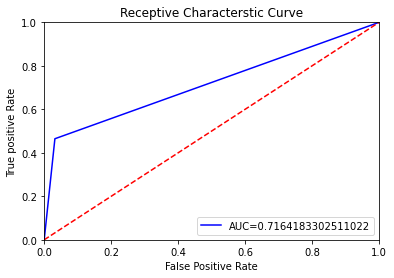

None


In [72]:
## Actual vs Predicted
from sklearn.metrics import confusion_matrix
df=pd.DataFrame({'actual':y_test,'predicted':y_RFC.flatten(),'True/false':y_test==y_RFC})

df

print(confusionMatrix(df))

Accuracy Score = 0.8672


Confusion Matrix
predicted     0    1   All
actual                    
0          1932   71  2003
1           261  236   497
All        2193  307  2500


Calssification Report
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      2003
           1       0.77      0.47      0.59       497

    accuracy                           0.87      2500
   macro avg       0.82      0.72      0.75      2500
weighted avg       0.86      0.87      0.85      2500



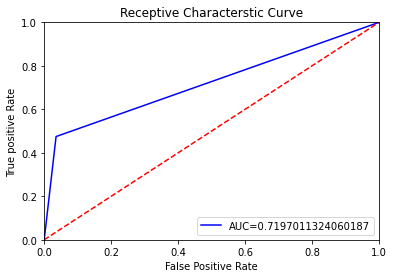

None


In [73]:
## Actual vs Predicted
from sklearn.metrics import confusion_matrix
df=pd.DataFrame({'actual':y_test,'predicted':y_pred.flatten(),'True/false':y_test==y_pred})

df

print(confusionMatrix(df))

In [88]:
df.value_counts(normalize=True)

actual  predicted  True/false
0       0          True          0.7728
1       0          False         0.1044
        1          True          0.0944
0       1          False         0.0284
dtype: float64

In [91]:
df1['prediction'].value_counts()


0    567
1     77
Name: prediction, dtype: int64